In [233]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [234]:
from matplotlib import pyplot as plt
from matplotlib import colors as colors
import numpy as np

import sys 
sys.path.append('../')
import Utils.utils as util
from importlib import reload
reload(util)

from sklearn.linear_model import Lasso
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import normalize

np.set_printoptions(threshold=np.inf) #print full arrays
from sklearn import linear_model

In [235]:
def split_patch(patch):
    h = patch.shape[0]
    #Convert one patch into a column vector for training
    patch = patch.flatten()
    pixel_central = patch[(h*(h//2)+(h//2))*3:(h*(h//2)+(h//2))*3+3]
    patch_sans_central = np.delete(patch, range((h*(h//2)+(h//2))*3, (h*(h//2)+(h//2))*3+3))
    return np.array((patch_sans_central, pixel_central))
    
def convert_patch_into_vector(patch):
    #Convert one patch into a column vector for training
    #patch = patch.flatten()
    h = patch.shape[0]
    patch = np.reshape(patch, h*h*3)
    return np.array(patch)

def convert_vector_into_patch(vector, h):
    #Convert a one column vector into a patch of size h
    return vector.reshape((h,h,7))
    
def convert_patches_into_training_set(patches):
    #Convert a set of patches into a set of vectors
    return np.array(list(map(convert_patch_into_vector, patches))).T

def find_index_noisy_lines(label):
    """
    indexes = []
    for index, value in enumerate(label):
        if(value == -1):
            indexes.append(index)
    """
    label = np.array(label)
    indexes = np.where(label < 0)
    return indexes

def delete_all_indexes_from(dictionary, label):
    indexes = find_index_noisy_lines(label)
    dictionary = np.delete(dictionary, indexes , 0)
    label = np.delete(label, indexes , 0)
    
    return (dictionary, label)    

#test the alpha on a lot of cleared patches and returns an average value
def estimate_alpha(noisy_image, dictionary_full, h):
    lassocv = linear_model.LassoCV()
    listalpha = []
    width = noisy_image.shape[1]
    height = noisy_image.shape[0]
    #params
    pas = h+10
    start = h//2
    endx = height-h//2
    endy = width-h//2
    #end params
    i=0
    total = int( (endx-pas)/pas * (endy-pas)/pas )
    for x in range(start,endx,pas):
        for y in range(start,endy,pas):
            label = util.get_patch(x, y, h, noisy_image)
            label = list(convert_patch_into_vector(label))
            dictionary, label = delete_all_indexes_from(dictionary_full,label)
            lassocv.fit(dictionary_full, label)
            alpha_ = lassocv.alpha_
            listalpha.append(alpha_)
            i+=1
            if(i%10==0): print(i, "/", total)
    return np.mean(np.array(listalpha))
    

def inpaint_image(noisy_image, dictionary, coord_noisy_pix, h, clear_image):
    noisy_image_orig = np.array(noisy_image)
    dictionary_full = np.array(dictionary)
    
    #todo question: vérifier qu'il faut bien faire le lassocv pour trouver le alpha sur le clear?
    lassocv = linear_model.LassoCV(max_iter=1000)  #1000 by default, 100 works OK
    """
    y, x = coord_noisy_pix[0]
    label = util.get_patch(x, y, h, noisy_image)
    #label = util.get_patch(x, y, h, clear_image)
    label = list(convert_patch_into_vector(label))
    lassocv.fit(dictionary_full, label)
    alpha_ = lassocv.alpha_
    """
    #alpha_ = estimate_alpha(noisy_image, dictionary_full, h)
    #autre idée: en prendre 10 aléatoirement
    alpha_ = 92 #calculé pour 12.jpg
    
    #alpha_ = 0.01
    
    print("alpha = ", alpha_)
       
    i = 0
    nbiter  = int(len(coord_noisy_pix))
    while i < nbiter: # DONT USE FOR FOR THIS BECAUSE WE WILL MODIFY THE LIST
        x, y  = coord_noisy_pix[0]
        
        if(i%10==0): print( i, " / ",  nbiter)
        
        #print("Correction de : (", x, ", ", y,")")
        patch = util.get_patch(x, y, h, noisy_image)
        labelfull = list(convert_patch_into_vector(patch))
        
        #print("labelfull : ", labelfull)
        
        dictionary = np.array(dictionary_full)
        dictionary, label = delete_all_indexes_from(dictionary,labelfull)

        #print("--- lasso regression ---")
        
        #recalcule du alpha à chaque patch
        if(i%1==0) :
            lassocv.fit(dictionary, label)
            alpha_ = lassocv.alpha_
            print("alpha = ", alpha_)
    
        #fin recalcule du alpha
        
        model = Lasso(fit_intercept=True,alpha=alpha_,positive=True)
        
        model.fit(dictionary, label)
        
        res = model.predict(dictionary_full)
        
        #coef = model.coef_.reshape((1,-1)) #poids
        #print("nb patch not at zero: ", np.count_nonzero(model.sparse_coef_.toarray()), " / ", coef.shape[1])
       
        # corrige juste le pixel central
        """
        newPixel = util.get_centered_pixel(res, h)
        print("new pixel (lasso): ", newPixel)
        noisy_image[x][y] = newPixel
        """
        
        def removearray(L,arr):
            ind = 0
            size = len(L)
            while ind != size and not np.array_equal(L[ind],arr):
                ind += 1
            if ind != size:
                L.pop(ind)
            else:
                raise ValueError('array not found in list.')
        
        # corrige tous les pixels noirs dans le patch
        labelfull = np.array(labelfull)
        list_indexes_noise = np.where(labelfull < 0)[0]     
        #print(list_indexes_noise)   
        indexeach3 = list(range(0,len(list_indexes_noise),3))
        listindexes2 = list_indexes_noise[indexeach3] #on prend que 1 sur 3 car 3 valeurs par pixel
        xpatch = x-h//2
        ypatch = y-h//2
        for val in listindexes2:
            val = (val/3)
            xlocal = int((val)//h)
            ylocal = int(val-(xlocal)*h)
            #print("xlocal = ",xlocal," ylocal=",ylocal)
            xglobal = xpatch + xlocal
            yglobal = ypatch + ylocal
            #print("xglobal=",xglobal," yglobal=",yglobal)
            patch = res.reshape(h,h,3)
            newpixel = patch[xlocal, ylocal]
            noisy_image[xglobal][yglobal] = newpixel
            #supprimer de la liste pour pas le refaire
            coord_noisy_pix = list( coord_noisy_pix)
            currentpixel = [xglobal, yglobal] #ok vérifié
            #print("remove : ", currentpixel)
            
            removearray(coord_noisy_pix, np.array(currentpixel))
            coord_noisy_pix = list( coord_noisy_pix)
            #print("left to correct : ",len(coord_noisy_pix))
            i = i + 1
            if(i%10==0): print( i, " / ",  nbiter)
            
            
        
        #Test a supprimer
        #_,clear_patches = util.get_patches(noisy_image, h, width, height)
        #dictionary_full = convert_patches_into_training_set(clear_patches)
        #print("shape : ", dictionary_full.shape)

    util.display_im(noisy_image_orig)
    util.display_im(noisy_image)

taille de l'image :  (120, 200, 3)
nb pixels à corriger:  (100, 100, 2)
200  ,  120
nbclear: 68


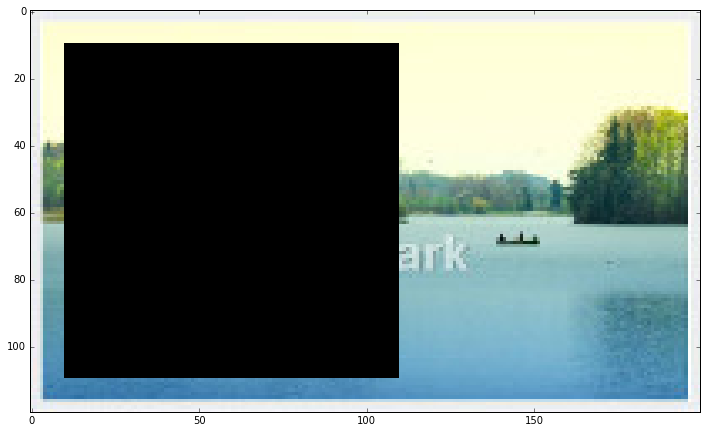

In [236]:
%matplotlib inline
img_matrice = util.read_im("Data/imgdataset/10small.jpg")

print("taille de l'image : ", img_matrice.shape)

#util.display_im(img_matrice)

#Taille des patchs
h=15 #nombre impair

noisy_image, deletepixels = util.delete_rect(img_matrice, 10, 10, 100, 100) #66, 55, 75, 15
#10small 65, 50, 80, 15
#12.jpg 85, 75, 30, 6

print("nb pixels à corriger: ", np.array(deletepixels).shape)

width = img_matrice.shape[1]
height = img_matrice.shape[0]

print(width," , ", height)

util.display_im(noisy_image)

_,clear_patches = util.get_patches(noisy_image, h, width, height)

nbclear = np.shape(clear_patches)[0]
print("nbclear:", nbclear)

In [237]:
training = convert_patches_into_training_set(clear_patches)
print(training.shape)

(675, 68)


In [238]:
a = np.array([[1, 'a'], [2, 'a'], [3, 'a'], [4, 'a'], [5, 'a'], [6, 'a'], [7, 'a'], [8, 'a'], [9, 'a']])
print(a.shape)    
a = a.reshape(3,3,2)
print(a.shape)
print("center=",util.get_centered_pixel(a, 3))

#coefsize = (1, 2510)   dicofullsize = (27, 2510)  ressize= (27, 2510)
coef = np.array([0,1,2])
coef = coef.reshape(-1,1)
print(coef.shape)
dico = [1,2,3]
coef.T*dico

(9, 2)
(3, 3, 2)
center= ['5' 'a']
(3, 1)


array([[0, 2, 6]])

1  2  3  4
5  6  7  8
9 10 11 12

In [ ]:
def spyral_transformation(a):
    out = []
    while (a.size):
        out.append(a[0])
        a = np.rot90(np.delete(a, 0, 0))
    return np.concatenate(out)

spyral_transformation(a)

array([['1', 'a'],
       ['2', 'a'],
       ['3', 'a'],
       ['6', 'a'],
       ['9', 'a'],
       ['8', 'a'],
       ['7', 'a'],
       ['4', 'a'],
       ['5', 'a']],
      dtype='<U21')

In [ ]:
deletepixels_transformed = spyral_transformation(np.array(deletepixels))

inpaint_image(noisy_image, training, deletepixels_transformed, h, img_matrice)

alpha =  92
0  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  68.7763377047
10  /  10000
20  /  10000
30  /  10000
40  /  10000
50  /  10000
60  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  66.2403309216
70  /  10000
80  /  10000
90  /  10000
100  /  10000
110  /  10000
120  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  64.6396598662
130  /  10000
140  /  10000
150  /  10000
160  /  10000
170  /  10000
180  /  10000
190  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  69.080349695
200  /  10000
210  /  10000
220  /  10000
230  /  10000
240  /  10000
250  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  262.334171234
260  /  10000
270  /  10000
280  /  10000
290  /  10000
300  /  10000
310  /  10000
320  /  10000
320  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  240.595894834
330  /  10000
340  /  10000
350  /  10000
360  /  10000
370  /  10000
380  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  234.250762206
390  /  10000
400  /  10000
410  /  10000
420  /  10000
430  /  10000
440  /  

/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


10000
alpha =  235.362676184
450  /  10000
460  /  10000
470  /  10000
480  /  10000
490  /  10000
500  /  10000
510  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  233.696015604
520  /  10000
530  /  10000
540  /  10000
550  /  10000
560 

/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


 /  10000
570  /  10000
alpha =  71.0810105323
580  /  10000
590  /  10000
600  /  10000
610  /  10000
620  /  10000
630  /  10000
640  /  10000
640  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  248.668372052
650  /  10000
660  /  10000
670  /  10000
680  /  10000
690  /  10000
700  / 

/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


 10000
alpha =  223.557685418
710  /  10000
720  /  10000
730  /  10000
740  /  10000
750  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


760  /  10000
alpha =  103.46171309
770  /  10000
780  /  10000
790  /  10000
800  /  10000
800  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  14.2984367179
810  /  10000
820  /  10000
830  /  10000
840  /  10000
850  /  10000
860  /  10000
alpha =  10.6117851051
870  /  10000
880  /  10000
890  /  10000
900  /  10000
910  /  10000
920  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  0.682307819914
930  /  10000
940  /  10000
950  /  10000
960  /  10000
970  /  10000
980  /  10000
990  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  53.2017668553
1000  /  10000
1010  /  10000
1020  /  10000
1030  /  10000
1040  /  10000
1050  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  22.0453243886
1060  /  10000
1070  /  10000
1080  /  10000
1090  /  10000
1100  /  10000
1110  /  10000
1120  /  10000
1120  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  1215.5059226
1130  /  10000
1140  /  10000
1150  /  10000
1160  /  10000
1170  /  10000
1180  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  56.324146535
1190  /  10000
1200  /  10000
1210  /  10000
1220  /  10000
1230  /  10000
1240  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  13.5233917153
1250  /  10000
1260  /  10000
1270  /  10000
1280  /  10000
1290  /  10000
1300  /  10000
1310  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  5.95423278987
1320  /  10000
1330  /  10000
1340  /  10000
1350  /  10000
1360  /  10000
1370  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  1.23398425987
1380  /  10000
1390  /  10000
1400  /  10000
1410  /  10000
1420  /  10000
1430  /  10000
1440  /  10000
1440  /  10000
alpha =  1.9229270062
1450  /  10000
1460  /  10000
1470  /  10000
1480  /  10000
1490  /  10000
1500  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  1.45314868408
1510  /  10000
1520  /  10000
1530  /  10000
alpha =  126.848661825
1540  /  10000
1550  /  10000
1560  /  10000
1570  /  10000
1580  /  10000
1590  /  10000
1600  /  10000
1600  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  176.559500142
1610  /  10000
1620  /  10000
1630  /  10000
1640  /  10000
1650  /  10000
1660  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  210.197857398
1670  /  10000
1680  /  10000
1690  /  10000
1700  /  10000
1710  /  10000
1720  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  238.182593858
1730  /  10000
1740  /  10000
1750  /  10000
1760  /  10000
1770  /  10000
1780  /  10000
1790  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  225.970671942
1800  /  10000
1810  /  10000
1820  /  10000
1830  /  10000
1840  /  10000
1850  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  234.324121289
1860  /  10000
1870  /  10000
1880  /  10000
1890  /  10000
1900  /  10000
1910  /  10000
1920  /  10000
1920  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  231.070661657
1930  /  10000
1940  /  10000
1950  /  10000
1960  /  10000
1970  /  10000
1980  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  222.234538959
1990  /  10000
2000  /  10000
2010  /  10000
2020  /  10000
2030  /  10000
2040  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  240.176521317
2050  /  10000
2060  /  10000
2070  /  10000
2080  /  10000
2090  /  10000
2100  /  10000
2110  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  242.860226513
2120  /  10000
2130  /  10000
2140  /  10000
2150  /  10000
2160  /  10000
2170  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  243.026043286
2180  /  10000
2190  /  10000
2200  /  10000
2210  /  10000
2220  /  10000
2230  /  10000
2240  /  10000
2240  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  835.04893102
2250  /  10000
2260  /  10000
2270  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  83.4708681322
2280  /  10000
2290  /  10000
2300  /  10000
2310  /  10000
2320  /  10000
2330  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  91.5589790349
2340  /  10000
2350  /  10000
2360  /  10000
2370  /  10000
2380  /  10000
2390  /  10000
2400  /  10000
2400  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  33.5610674567
2410  /  10000
2420  /  10000
2430  /  10000
2440  /  10000
2450  /  10000
2460  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  64.6704573094
2470  /  10000
2480  /  10000
2490  /  10000
2500  /  10000
2510  /  10000
2520  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  115.838882928
2530  /  10000
2540  /  10000
2550  /  10000
2560  /  10000
2570  /  10000
2580  /  10000
2590  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  18.9755823179
2600  /  10000
2610  /  10000
2620  /  10000
2630  /  10000
2640  /  10000
2650  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  59.3777759245
2660  /  10000
2670  /  10000
2680  /  10000
2690  /  10000
2700  /  10000
2710  /  10000
2720  /  10000
2720  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  43.4344781516
2730  /  10000
2740  /  10000
2750  /  10000
2760  /  10000
2770  /  10000
2780  /  10000
alpha =  113.826784221
2790  /  10000
2800  /  10000
2810  /  10000
2820  /  10000
2830  /  10000
2840  /  10000
alpha =  11.029371639
2850  /  10000
2860  /  10000
2870  /  10000
2880  /  10000
2890  /  10000
2900  /  10000
2910  /  10000
alpha =  125.731994262
2920  /  10000
2930  /  10000
2940  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  58.4066175778
2950  /  10000
2960  /  10000
2970  /  10000
2980  /  10000
2990  /  10000
3000  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  51.4243876162
3010  /  10000
3020  /  10000
3030  /  10000
3040  /  10000
3050  /  10000
3060  /  10000
3070  /  10000
alpha =  49.5444255843


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


3080  /  10000
3090  /  10000
3100  /  10000
3110  / 

/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


 10000
3120  /  10000
3130  /  10000
alpha =  1.68184567051
3140  /  10000
3150  /  10000
3160  /  10000
3170  /  10000
3180  /  10000
3190  /  10000
3200  /  10000
3200  /  10000
alpha =  1.83608224168


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


3210  /  10000
3220  /  10000
3230  /  10000
3240  /  10000
3250  / 

/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


 10000
3260  /  10000
alpha =  2.27483058064
3270  /  10000
3280  /  10000
3290  /  10000
3300  /  10000
3310  /  10000

/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)



3320  /  10000
alpha =  2.11007269375
3330  /  10000
3340  /  10000
3350  /  10000
3360  /  10000
3370  /  10000
3380  /  10000
3390  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  2.41600889448
3400  /  10000
3410  /  10000
3420  /  10000
3430  /  10000
3440  /  10000
3450  /  10000
alpha =  22.3777781409
3460  /  10000
3470  /  10000
3480  /  10000
3490  /  10000
3500  /  10000
3510  /  10000
3520  /  10000
3520  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  1.33578907707
3530  /  10000
3540  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


3550  /  10000
3560  /  10000
3570  /  10000
3580  /  10000
alpha =  2.95769985685
3590  /  10000
3600  /  10000
3610  /  10000
alpha =  41.3509799116
3620  /  10000
3630  /  10000
3640  /  10000
3650  /  10000
3660  /  10000
3670  /  10000
3680  /  10000
3680  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  8.86474531665
3690  /  10000
3700  /  10000
3710  /  10000
3720  /  10000
3730  /  10000
3740  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  18.1812832062
3750  /  10000
3760  /  10000
3770  /  10000
3780  /  10000
3790  /  10000
3800  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  8.67697950913
3810  /  10000
3820  /  10000
3830  /  10000
3840  /  10000
3850  /  10000
3860  /  10000
3870  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  447.96064826
3880  /  10000
3890  /  10000
3900  /  10000
3910  /  10000
3920  /  10000
3930  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  22.3929018513
3940  /  10000
3950  /  10000
3960  /  10000
3970  /  10000
3980  /  10000
3990  /  10000
4000  /  10000
4000  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  13.8101926839
4010  /  10000
4020  /  10000
4030  /  10000
4040  /  10000
4050  /  10000
4060  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  36.6519938277
4070  /  10000
4080  /  10000
4090  /  10000
4100  /  10000
4110  /  10000
4120  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  1.41592110644
4130  /  10000
4140  /  10000
4150  /  10000
4160  /  10000
4170  /  10000
4180  /  10000
4190  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  1.66196732654
4200  /  10000
4210  /  10000
4220  /  10000
alpha =  71.5908485076
4230  /  10000
4240  /  10000
4250  /  10000
4260  /  10000
4270  /  10000
4280  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  60.2813751304
4290  /  10000
4300  /  10000
4310  /  10000
4320  /  10000
4330  /  10000
4340  /  10000
4350  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  55.3431215184
4360  /  10000
4370  /  10000
4380  /  10000
4390  /  10000
4400  /  10000
4410  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  44.8408243002
4420  /  10000
4430  /  10000
4440  /  10000
4450  /  10000
4460  /  10000
4470  /  10000
4480  /  10000
4480  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  19.0436294938
4490  /  10000
4500  /  10000
4510  /  10000
4520  /  10000
4530  /  10000
4540  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  18.6157237298
4550  /  10000
4560  /  10000
4570  /  10000
4580  /  10000
4590  /  10000
4600  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  23.4372347113
4610  /  10000
4620  /  10000
4630  /  10000
4640  /  10000
4650  /  10000
4660  /  10000
4670  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  27.8436190058
4680  /  10000
4690  /  10000
4700  /  10000
4710  /  10000
4720  /  10000
4730  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  26.534099513
4740  /  10000
4750  /  10000
4760  /  10000
4770  /  10000
4780  /  10000
4790  /  10000
4800  /  10000
4800  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  2.41499108655
4810  /  10000
4820  /  10000
4830  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  4.84179252243
4840  /  10000
4850  /  10000
4860  /  10000
4870  /  10000
4880  /  10000
4890  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  14.0607641082
4900  /  10000
4910  /  10000
4920  /  10000
4930  /  10000
4940  /  10000
4950  /  10000
4960  /  10000
4960  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  38.6817270818
4970  /  10000
4980  /  10000
4990  /  10000
5000  /  10000
5010  /  10000
5020  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  48.44264321
5030  /  10000
5040  /  10000
5050  /  10000
5060  /  10000
5070  /  10000
5080  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  2.46256530589
5090  /  10000
5100  /  10000
5110  /  10000
5120  /  10000
5130  /  10000
5140  /  10000
5150  /  10000
alpha =  1132.69103836
5160  /  10000
5170  /  10000
5180  /  10000
5190  /  10000
5200  /  10000
5210  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  12.3586493988
5220  /  10000
5230  /  10000
5240  /  10000
5250  /  10000
5260  /  10000
5270  /  10000
5280  /  10000
5280  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  70.5723156507
5290  /  10000
5300  /  10000
5310  /  10000
5320  /  10000
5330  /  10000
5340  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  2.89690448085
5350  /  10000
5360  /  10000
5370  /  10000
alpha =  2.78074061198
5380  /  10000
5390  /  10000
5400  /  10000
5410  /  10000
5420  /  10000
5430  /  10000
5440  /  10000
5440  /  10000
alpha =  3.57060925021
5450  /  10000
5460  /  10000
5470  /  10000
5480  /  10000
5490  /  10000
5500  /  10000
alpha =  36.2554795041
5510  /  10000
5520  /  10000
5530  /  10000
5540  /  10000
5550  /  10000
5560  /  10000
alpha =  16.7934159991
5570  /  10000
5580  /  10000
5590  /  10000
5600  /  10000
5610  /  10000
5620

/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


  /  10000
5630  /  10000
alpha =  11.2145637062
5640  /  10000
5650  /  10000
5660  /  10000
5670  /  10000
5680  /  10000
5690  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  9.92085946751
5700  /  10000
5710  /  10000
5720  /  10000
5730  /  10000
5740  /  10000
5750  /  10000
5760  /  10000
5760  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  10.1222201653
5770  /  10000
5780  /  10000
5790  /  10000
5800  /  10000
5810  /  10000
5820  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  6.35163504124
5830  /  10000
5840  /  10000
5850  /  10000
5860  /  10000
5870  /  10000
5880  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  19.1787311928
5890  /  10000
5900  /  10000
5910  /  10000
5920  /  10000
5920  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  173.369138067
5930  /  10000
5940  /  10000
5950  /  10000
5960  /  10000
5970  /  10000
5980  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  228.822280289
5990  /  10000
6000  /  10000
6010  /  10000
6020  /  10000
6030  /  10000
6040  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  3.0920505453
6050  /  10000
6060  /  10000
6070  /  10000
6080  /  10000
6090  /  10000
6100  /  10000
6110  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  510.338836408
6120  /  10000
6130  /  10000
6140  /  10000
6150  /  10000
6160  /  10000
6170  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  13.2711229411
6180  /  10000
6190  /  10000
6200  /  10000
6210  /  10000
6220  /  10000
6230  /  10000
6240  /  10000
6240  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  15.079331266
6250  /  10000
6260  /  10000
6270  /  10000
6280  /  10000
6290  /  10000
6300  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  83.8121368131
6310  /  10000
6320  /  10000
6330  /  10000
6340  /  10000
6350  /  10000
6360  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  13.1839199624
6370  /  10000
6380  /  10000
6390  /  10000
6400  /  10000
6400  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  61.1059611072
6410  /  10000
6420  /  10000
6430  /  10000
6440  /  10000
6450  /  10000
6460  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  21.9920395828
6470  /  10000
6480  /  10000
6490  /  10000
6500  /  10000
6510  /  10000
6520  /  10000
alpha =  9.34034043824
6530  /  10000
6540  /  10000
6550  /  10000
6560  /  10000
6570  /  10000
6580  /  10000
6590  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  25.1346508908
6600  /  10000
6610  /  10000
6620  /  10000
6630  /  10000
6640  /  10000
6650  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  16.1738249221
6660  /  10000
6670  /  10000
6680  /  10000
6690  /  10000
6700  /  10000
6710  /  10000
6720  /  10000
6720  /  10000
alpha =  18.1927588116
6730  /  10000
6740  /  10000
6750  /  10000
6760  /  10000
6770  /  10000
6780  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  9.05599563554
6790  /  10000
6800  /  10000
6810  /  10000
6820  /  10000
6830  /  10000
6840  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  3.15207622396
6850  /  10000
6860  /  10000
6870  /  10000
6880  /  10000
6880  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  103.77718921
6890  /  10000
6900  /  10000
6910  /  10000
6920  /  10000
6930  /  10000
6940  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  57.8670248743
6950  /  10000
6960  /  10000
6970  /  10000
6980  /  10000
6990  /  10000
7000  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  99.8678179999
7010  /  10000
7020  /  10000
7030  /  10000
7040  /  10000
7050  /  10000
7060  /  10000
7070  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  123.260627435
7080  /  10000
7090  /  10000
7100  /  10000
7110  /  10000
7120  /  10000
7130  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  625.581326166
7140  /  10000
7150  /  10000
7160  /  10000
7170  /  10000
7180  /  10000
7190  /  10000
7200  /  10000
7200  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  18.7112169735
7210  /  10000
7220  /  10000
7230  /  10000
7240  /  10000
7250  /  10000
7260  /  10000


/users/Etu7/3262287/.local/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha =  29.1883990267
7270  /  10000
7280  /  10000
7290  /  10000
